## To Do
. CLOSED LOOP: the 250 trials of free exploration (whether or not they were preceded by training)
logistic regression

For each participant, define y as a 250 element vector, with each element being 0 if the participant stayed on the same task as on the previous trial, and 1 if she switched tasks. Then use logistic regression to fit y = b*X. I.e., fit y as a linear combination of the factors of interest, each weighted by its fitted coefficient b.
The matrix X has the variables of interest, of which there can be many. Here is a list I propose:
* x0: baseline (average propensity to switch or stay, which may differ in interesting ways by participant)
* x1: total nb of trials played so far (switch/stay strategy may change as a function of time horizon remaining to learn)
* x2: nb of trials played in the current stretch of this task 
* x3: total nb of trials played so far on the current task (in all stretches)
* x4: **relative** nb of trials played so far on the current task (total nb of trials on this task normalized by the mean across all tasks)
* x5: the variance in the nb of trials allocated so far to all tasks (perhaps people will tend to switch more often if their allocation so far was more skewed - i.e., they didn't sample all the tasks - see below for explanation).
* x6: %correct on the current task in the current stretch
* x7: % correct on the current task across all the trials played so far
* x8: relative %correct on the current task (normalized by %correct for all the others)
* x9: variance in %correct across all tasks
* x10: LP on the current task in the current stretch
* x11: LP on the current task across all trials played so far
* x12: relative LP on the current task, normalized by the LP on the others
* x13: variance in LP across all tasks

Notes:
1. The terms for variance (x13, x9 and x5) are meant to capture the possibility that people switch more often if they have not sampled all the tasks. I think that a simple way to do this is to take the variable of interest (LP, %correct or nb of trials allocated) and calculate its variance across the 4 tasks; high variance indicates a skewed distribution, and low variance, more even allocation. For instance, if a participant selected tasks 1-4 for, say, 100, 2,1,1 trials, this will have high variance and indicate a highly skewed distribution, whereas if she selected tasks 1-4 for 26, 26, 26 and 26 trials, this has 0 variance and a much more uniform distribution. 
2. Some of the variables may not be defined for all trials. For instance, x6 and x10 are not defined on the first trial after a switch. You can leave those as missing values if the fitting algorithm can deal with that. OTherwise, I would use a heuristic of defining them as the values on the last stretch of the same task. "The last stretch" can include the training trials if necessary.

The logistic regression above can be performed individually for each participant. So, your results will have 
13 coefficients * 100 participants * 5 experimental groups.
The visualization will consist of histograms showing the distribution of each coefficient across all participants. Ideally you would organize this in **one page with 13 columns (one per factor) and 5 rows (one per experimental group).**

In each histogram show with different colors the coefficients that are significantly > 0 (p < 0.05) or significantly < 0. Also show the mean of the distribution (with a vertical line) and some test comparing the mean to 0 (you may make the vertical line thick if p < 0.05 and thin otherwise). Keep the x-axis the same across rows so that we can easily see if some coefficient differed by experimental group.

For the future: 
I think that this is the simplest and most efficient way to do exploratory analysis. When we have the coefficients, we may consider doing further dimensionality reduction (PCA analysis?) to see if participants show groups of strategies.
Also for the future we can consider multinomial regression, where y is not just 1 or 0, but one of the tasks (1-4). But I think this is much more complex and we can get much of the same information with the logistic regression - so I would very much want to see this one first.



#New work

I propose the following to start with:

* Put all the trials together into a master vector, combining across all the participants that played any one game version (so, 4 groups of people)

* For each variable on our list, compute that variable for each trial; for instance, for variable [x1 = nb of trials played so far on the task], you will have a value for each trial in your master vector, and so on for all the other variables.

* Make two distributions of each variable - one for switch and the other for non-switch trials
Compare the distributions using some statistical test (best is Wilcoxon non-parametric test); if there is a significant difference this means that the variable in question correlates with switch/non-switch performance
To plot the data:

* I would like to see ONE page with several panels, one for each of the variables on the list
Each panel shows the pre-switch and pre-no-switch distributions superimposed, also showing their means and the p-value from the pairwise test
Make sure the y axis is fraction rather than number of trials since the numbers will vary widely between switch and non-switch trials
There are many ways to follow up on this, but let’s start here and see how it goes. If you finish before Tuesday you can upload the plots here and PY and I can give you feedback online.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import pandas as pd
import warnings

import seaborn as sns
sns.set(font_scale=1.5)
from scipy.stats import beta

from ipywidgets import widgets
from IPython.html.widgets import *

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(precision=2)

from __future__ import division

from sklearn.linear_model import LogisticRegression

import io
from IPython.nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)




/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
execute_notebook("Preprocessing.ipynb")

['free']
99
['free', 'train']
99
100
['free', 'test', 'train']
100
101


### Variables of interest

* splitCsvF
* splitCsvFTTI
* splitCsvFTTU
* splitSTI
* splitSTU

Calculating independent variables

In [6]:
len_trial= [len(i[:,1]) for i in splitCsvF]

#Form 2D array for each participant with 250 trials (101,250)
tasks=4
userSwitch = np.zeros((len(splitCsvF),250))
pred_userSwitch = np.zeros((len(splitCsvF),250))
X=np.zeros((len(splitCsvF),12,250))


#Initialize userSwitch
for index,user in enumerate(splitCsvF):
    
    #First element of each participant is zero
    c = user[:,1][0]
    #Iterate over trials-1
    for j in range(250-1):
        #If participant switches task, assign 1
        if c != user[:,1][j+1]:
            userSwitch[index][j+1]=1
            c = user[:,1][j+1]
    
#Setting independent variables
'''
for index,user in enumerate(splitCsvF):
    X[index][0]=[i for i in range(250)]
    X[index][1]=[ for ]
print (X[0][0])
'''
   
#number of correct answers
X7_count= np.zeros((len(splitCsvF),250,4))

for index,user in enumerate(splitCsvF):
    
    X2_c1 = 1
    c2 = 0
    X6_count = 0
    
   
    X6_id = splitCsvF[index][0][1]
    X3_t1 = X3_t2 = X3_t3 = X3_t4=0
    for j in range(250):
        #x1: total nb of trials played so far 
        X[index][0][j] = j+1
        
        #x2: nb of trials played in the current stretch of this task
        if userSwitch[index][j] == 1:
            X2_c1 = 1
            X[index][1][j] = X2_c1
            X2_c1+=1
        else:len_trial= [len(i[:,1]) for i in splitCsvF]

#Form 2D array for each participant with 250 trials (101,250)
        tasks=4
        X[index][1][j] = X2_c1
        X2_c1 += 1
        
        #x3: total nb of trials played so far on the current task
        X[index][2][j] = (splitCsvF[index][:,1][:(j+1)] == splitCsvF[index][:,1][j]).sum()
    
        #x4: relative nb of trials played so far on the current task
        X[index][3][j] = X[index][2][j]/X[index][0][j]
   
        #x5: the variance in the nb of trials allocated so far to all tasks
        X5_count = [(splitCsvF[index][:,1][:(j+1)] == k).sum() for k in range(tasks)] 
        X[index][4][j] = np.var(X5_count)
        
        #x6: %correct on the current task in the current stretch
        if userSwitch[index][j] == 1:
            X6_count = 0
            if splitCsvF[index][j][2]==1:
                X6_count += 1
            X[index][5][j]=(X6_count/(X2_c1-1))
        else:
            if splitCsvF[index][j][2]==1:
                X6_count += 1
            X[index][5][j]=(X6_count/(X2_c1-1))
       
       #x7: % correct on the current task across all the trials played so far 
        X7_count_tasks = [splitCsvF[index][splitCsvF[index][:,1][:(j+1)] == k] for k in range(tasks)]
        X7_count_correct = [(X7_count_tasks[k][:,2] == 1).sum() for k in range(tasks)]
        X[index][6][j]=X7_count_correct[splitCsvF[index][j][1]]/X[index][2][j]
        
        #x8  relative %correct on the current task (normalized by %correct for all the others)
        X[index][7][j] = X[index][6][j]/(sum(X7_count_correct)/X[index][0][j])

print X[0][0]
#print splitCsvF[0][:,1] == 3
#print splitCsvF[0][splitCsvF[0][:,1] == 3]

#for k in np.unique(splitCsvF[0][:,1]):
        #print k
#print X[1][5]
#print X[1][2]
#print X[0][0]
#print userSwitch[20]     
#print splitCsvF[20][:,1]



[   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.
   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.
   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.
   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.
   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.
   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.
   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.
   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.
  109.  110.  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.
  121.  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.  132.
  133.  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.  144.
  145.  146.  147.  148.  149.  150.  151.  152.  153.  154.  155.  156.
  157.  158.  159.  160.  161.  162.  163.  164.  1

In [ ]:
#Make Distributions on data



In [212]:
# fit a logistic regression model and store the class predictions
logreg = LogisticRegression(C=100)
print X[0][0].shape,userSwitch[0].shape
feature_cols = [X[0][0],X[0][1],X[0][2],X[0][3],X[0][4],X[0][5],X[0][6],X[0][7]]
#X_new = X[0][0]
y = userSwitch
log_reg = np.zeros((len(splitCsvF),250))
switch_count=0
for i in range(len(splitCsvF)):
    if i==32 or i==47 or i==65 or i==72:
        continue
    X_new= np.reshape(X[i][5],(250,1))
    switch_count += (y[i]).sum() 
    logreg.fit(X_new, y[i])
    log_reg[i] = logreg.predict(X_new)
print switch_count

(250,) (250,)
831.0


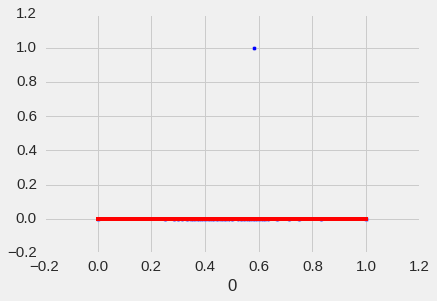

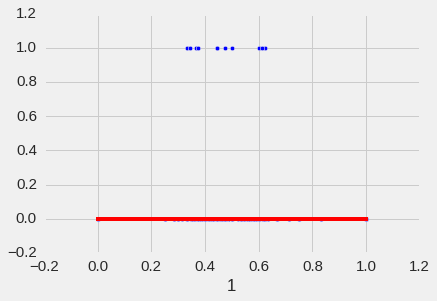

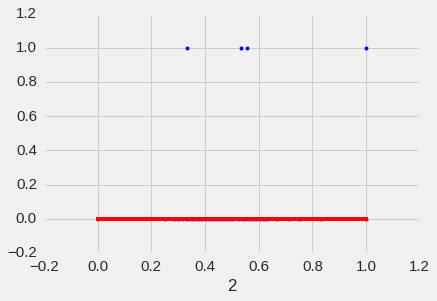

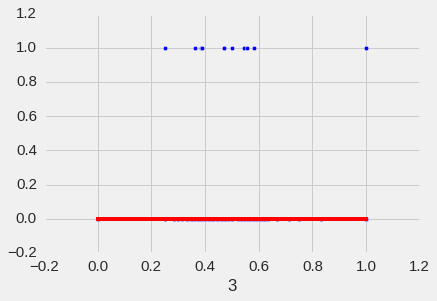

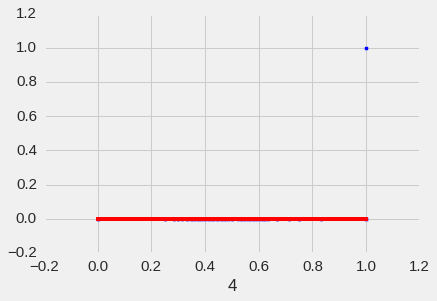

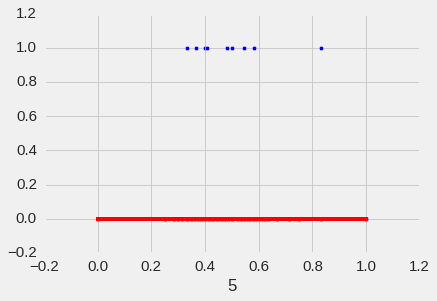

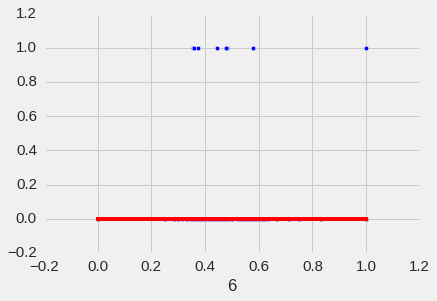

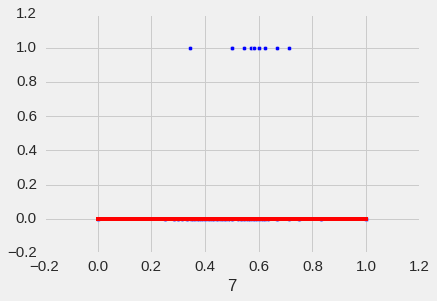

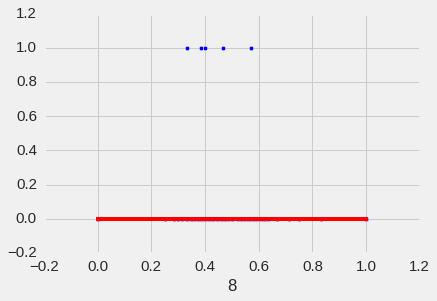

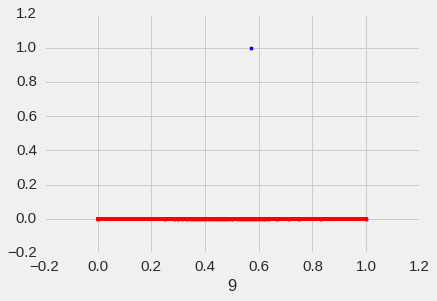

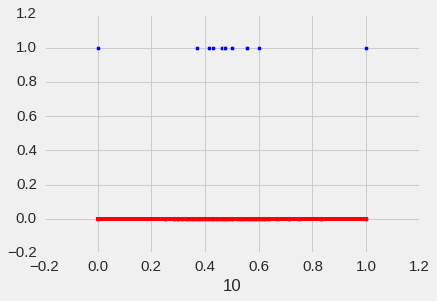

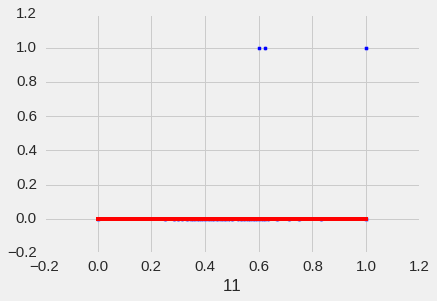

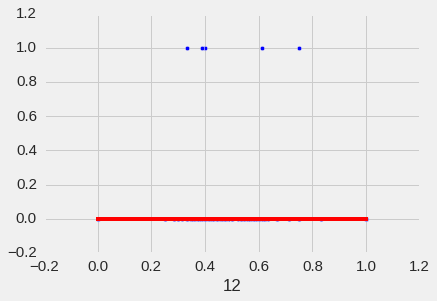

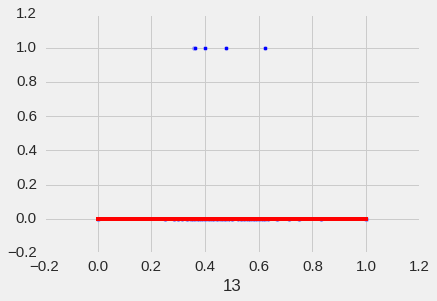

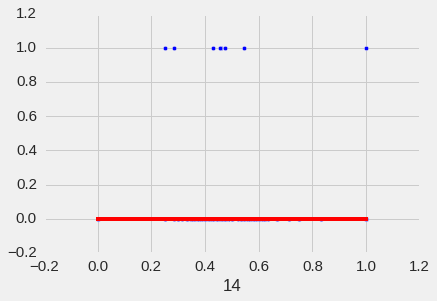

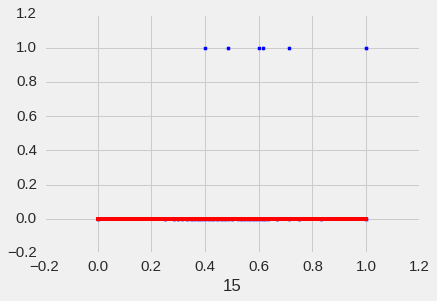

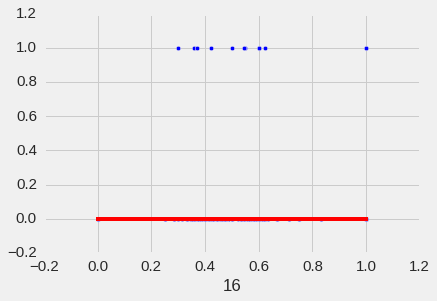

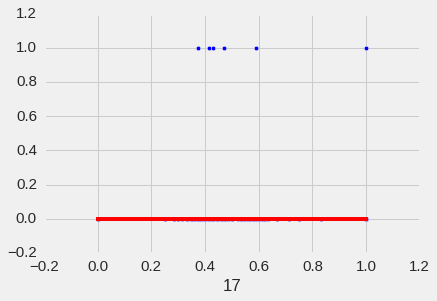

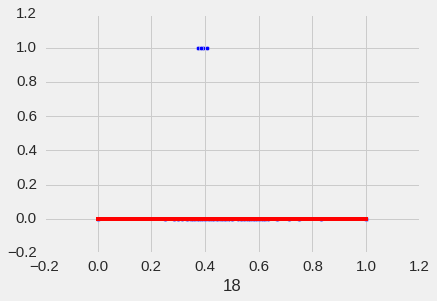

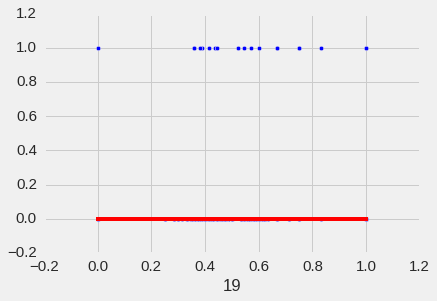

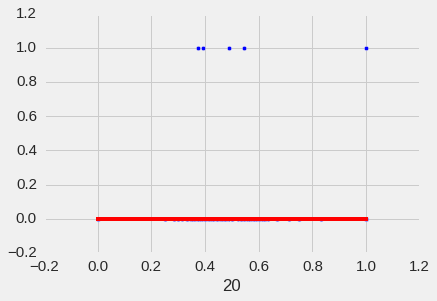

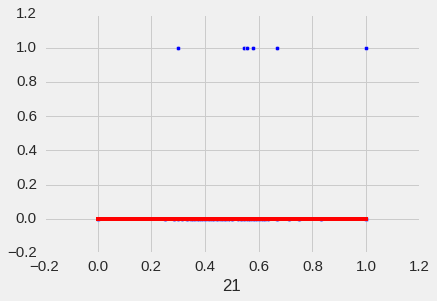

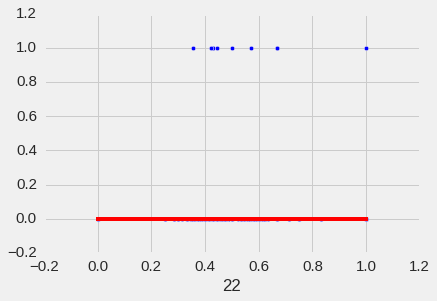

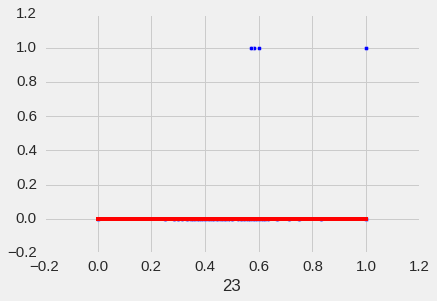

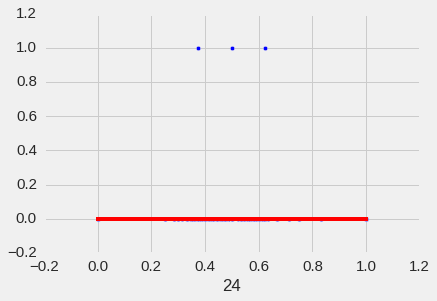

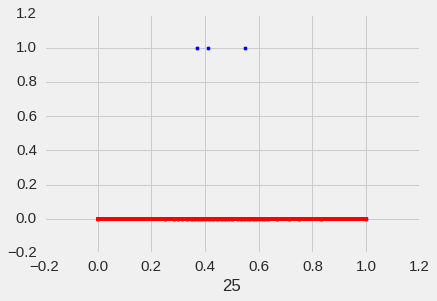

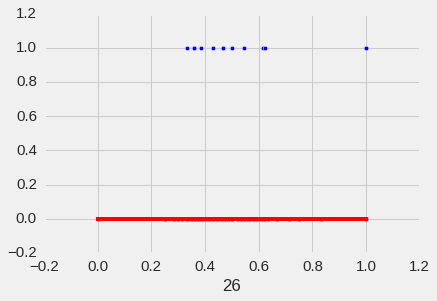

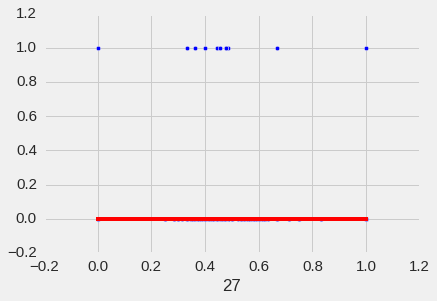

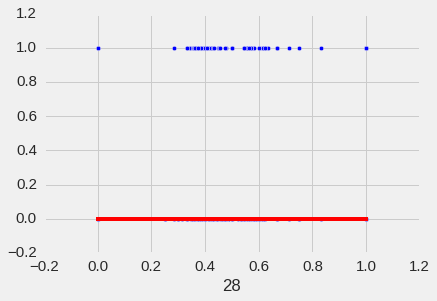

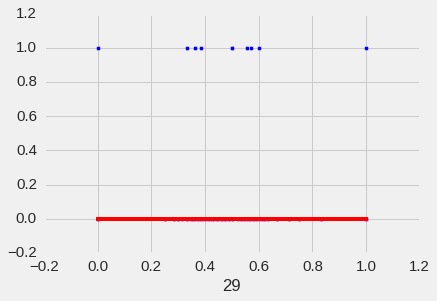

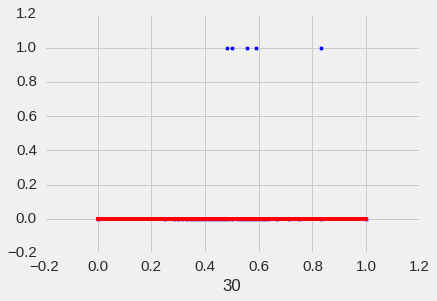

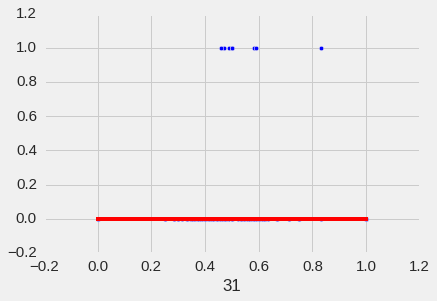

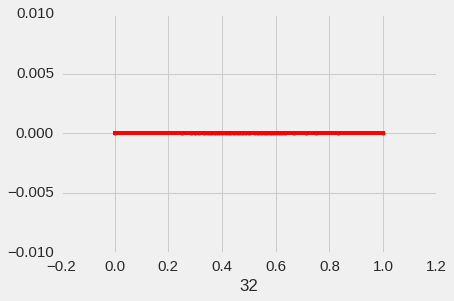

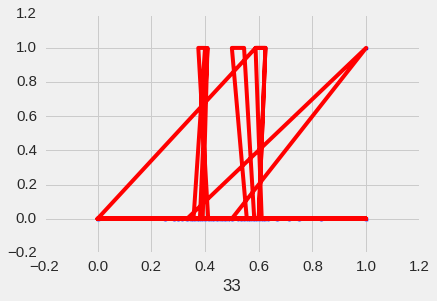

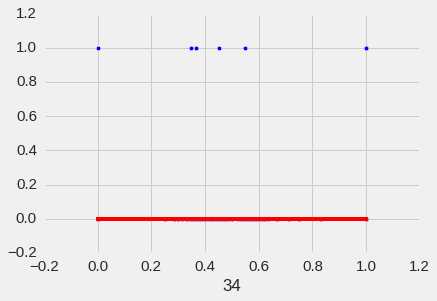

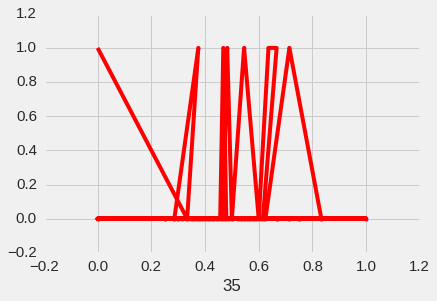

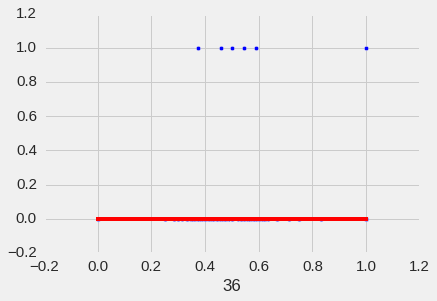

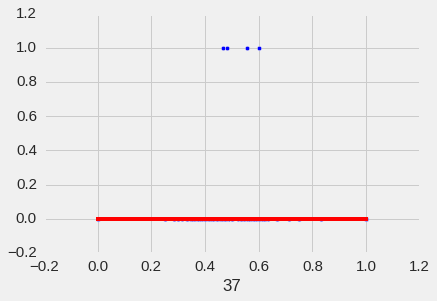

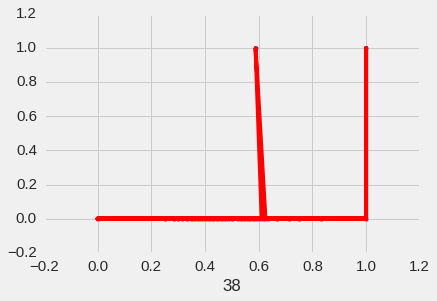

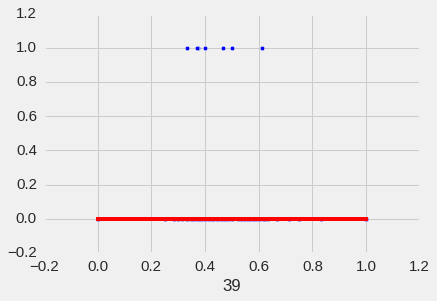

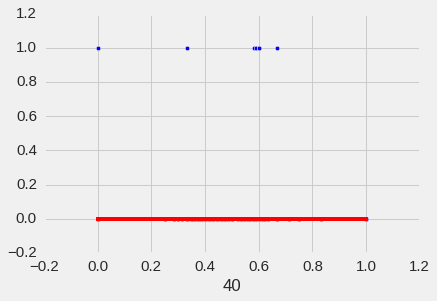

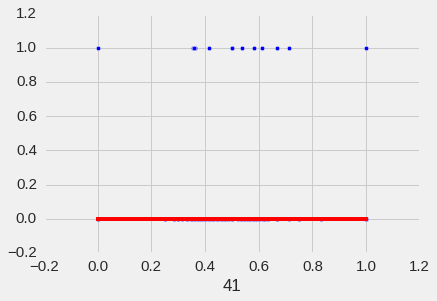

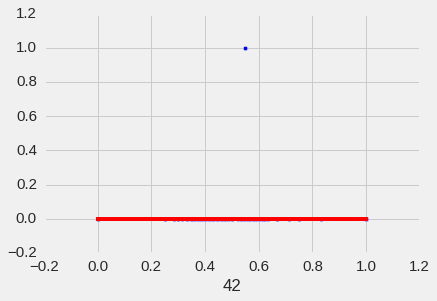

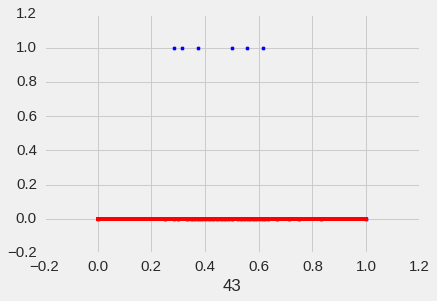

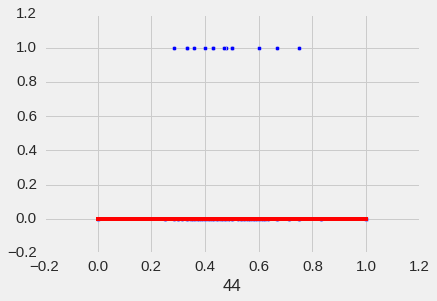

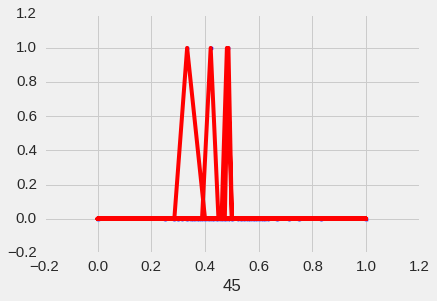

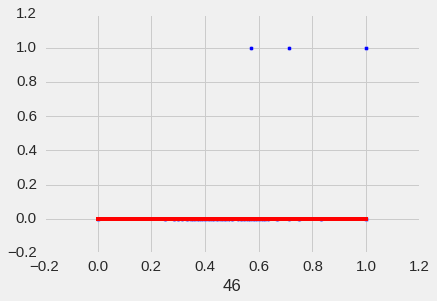

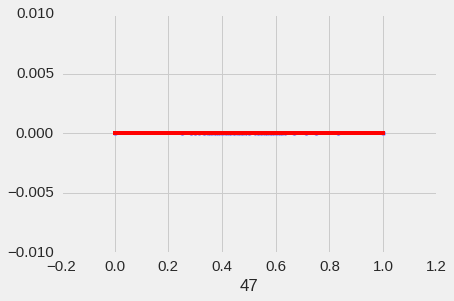

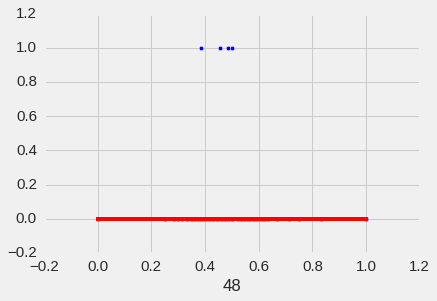

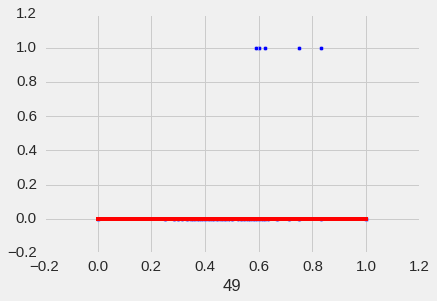

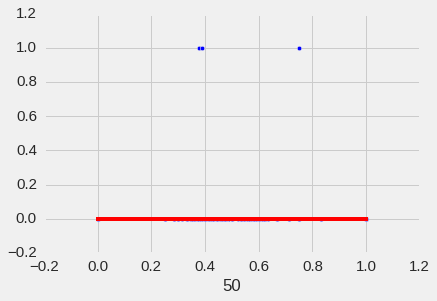

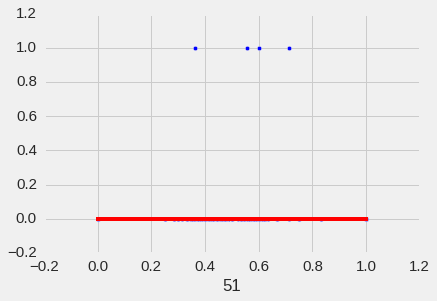

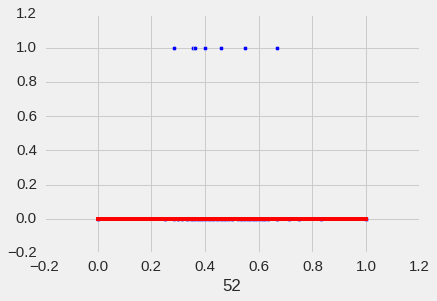

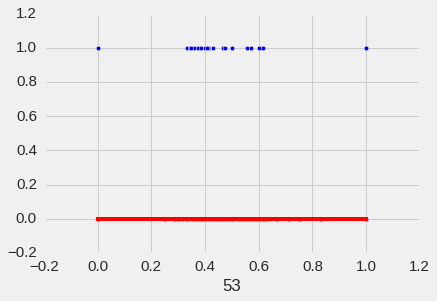

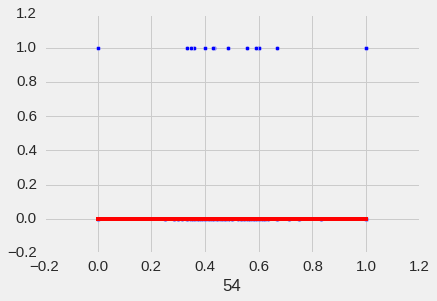

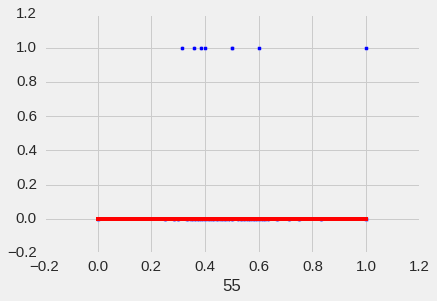

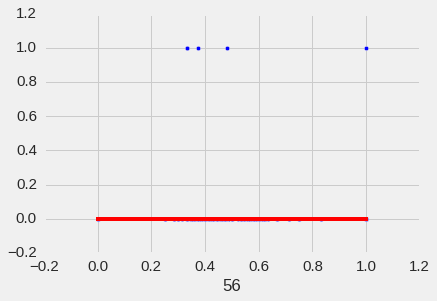

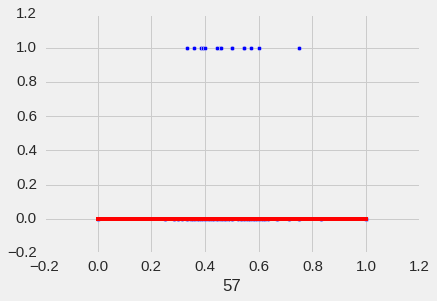

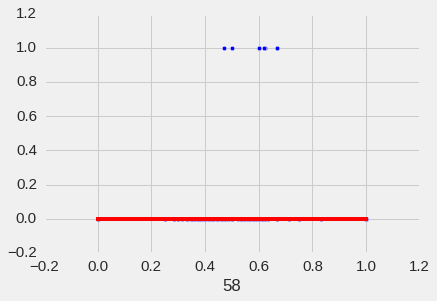

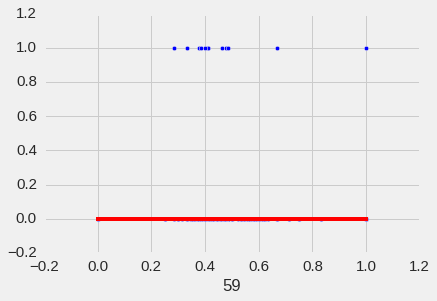

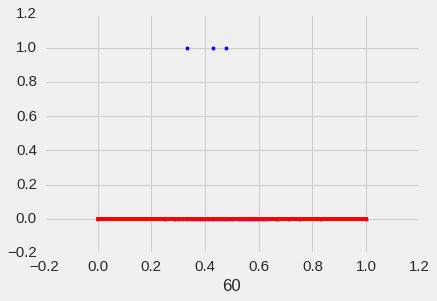

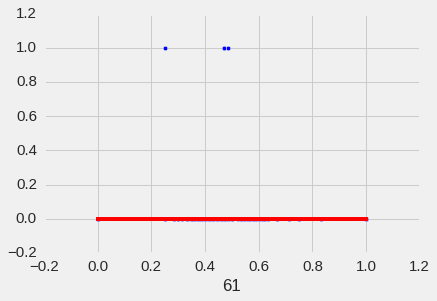

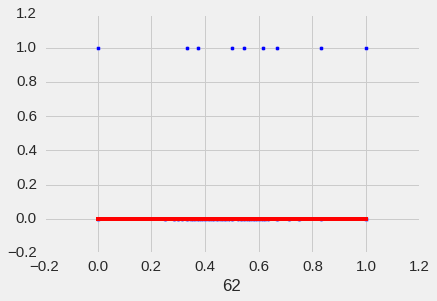

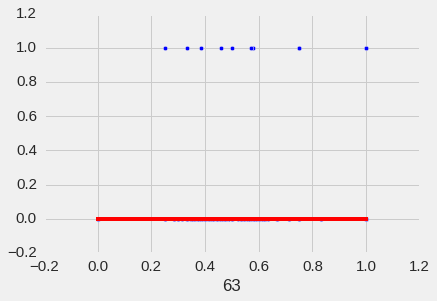

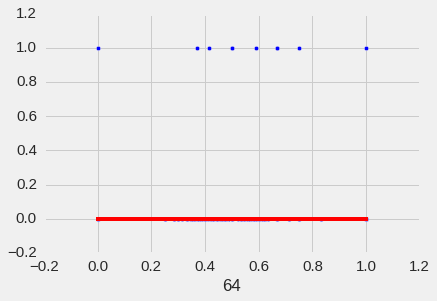

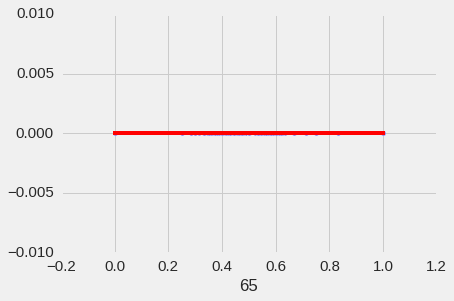

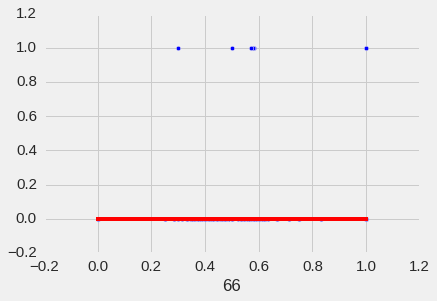

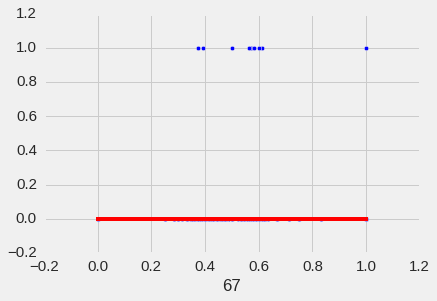

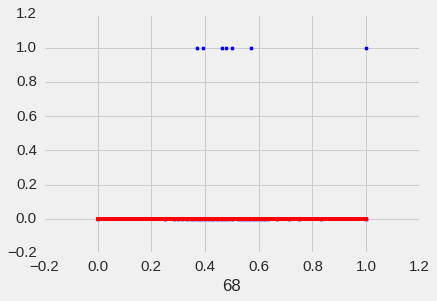

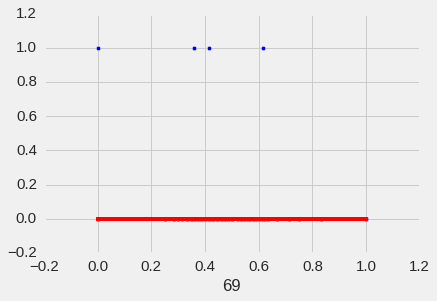

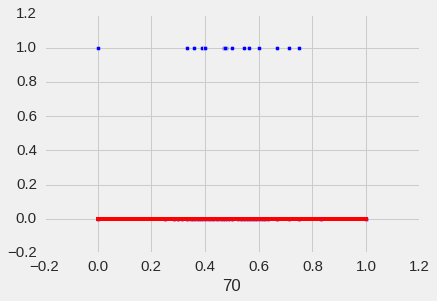

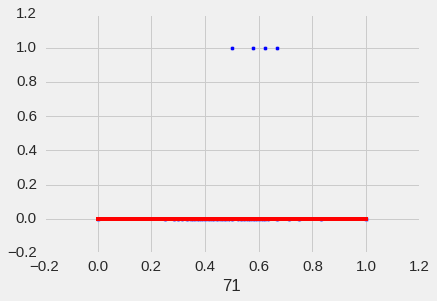

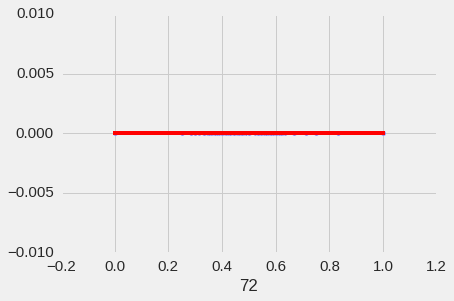

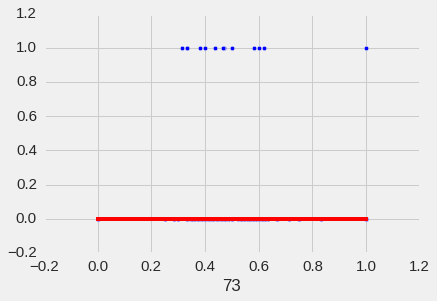

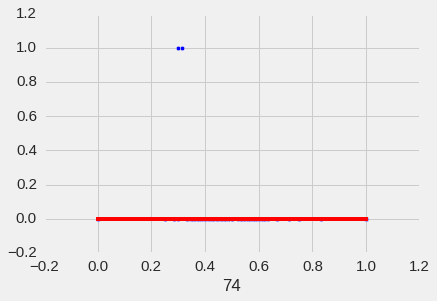

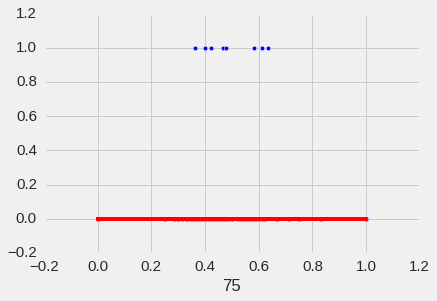

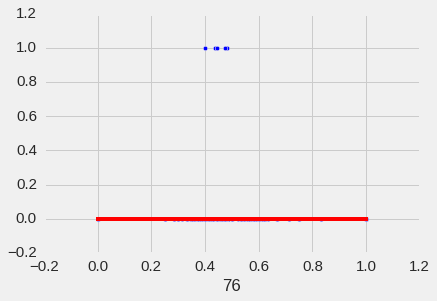

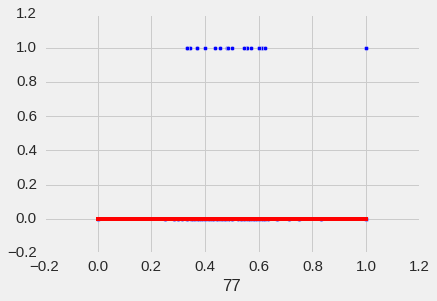

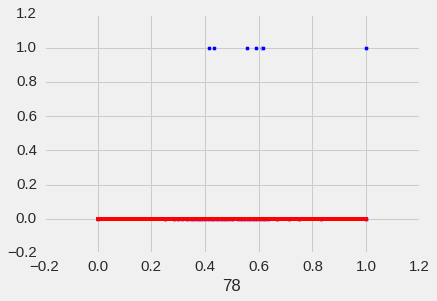

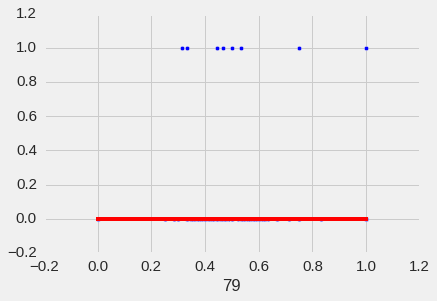

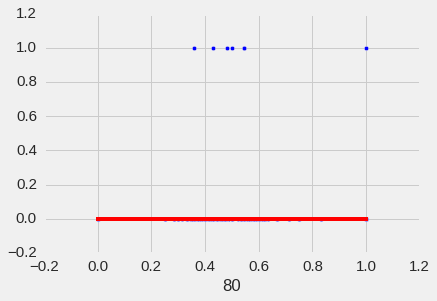

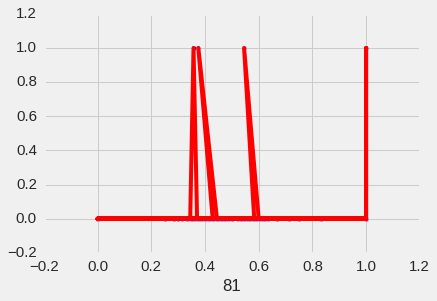

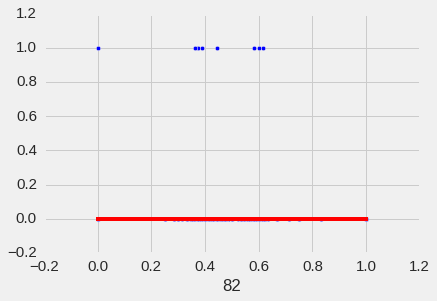

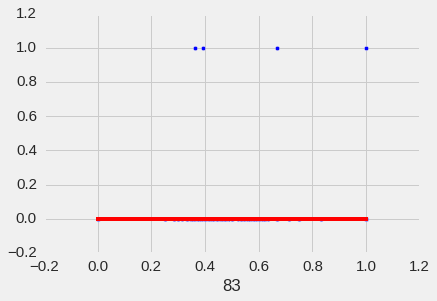

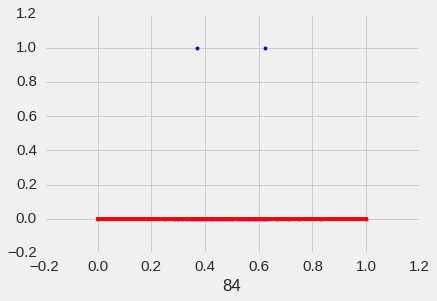

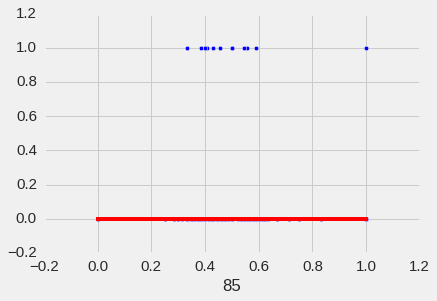

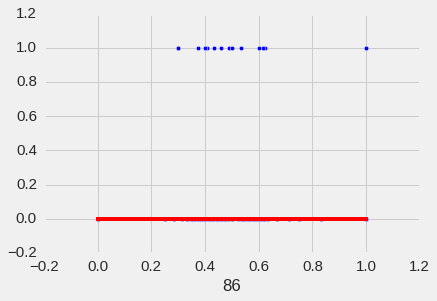

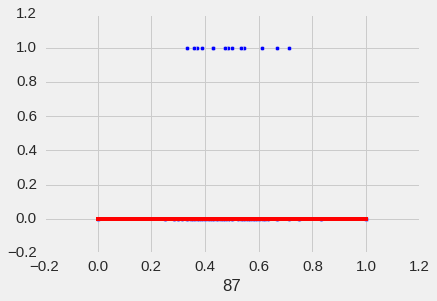

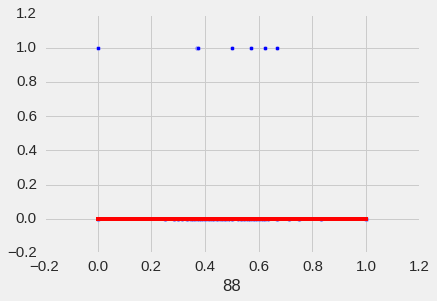

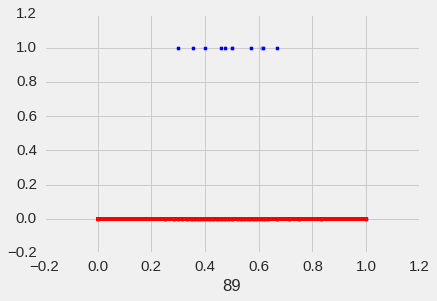

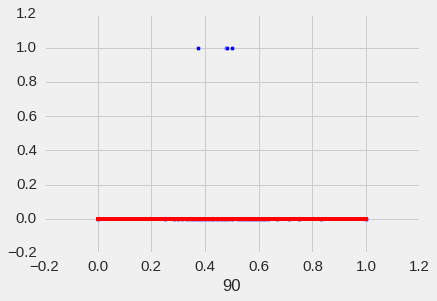

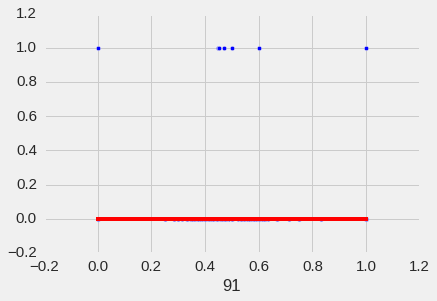

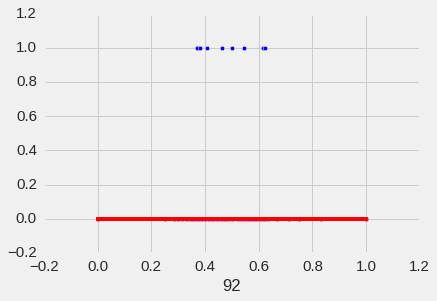

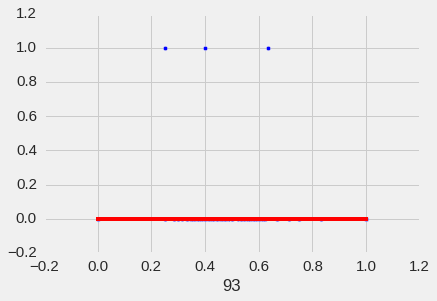

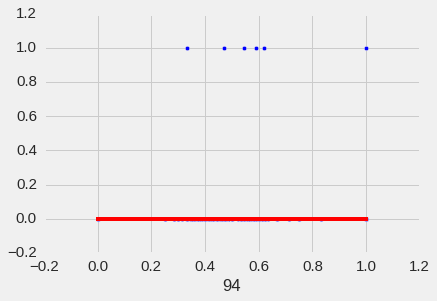

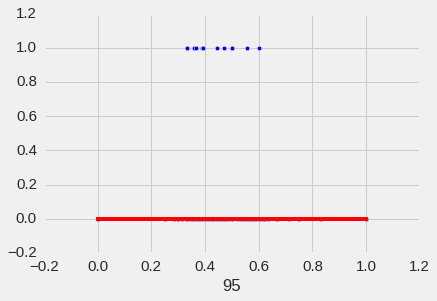

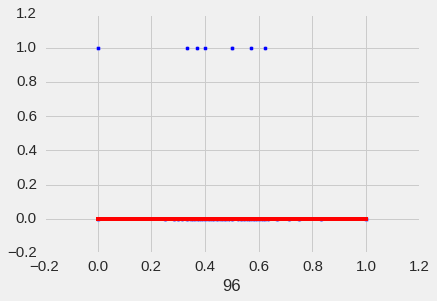

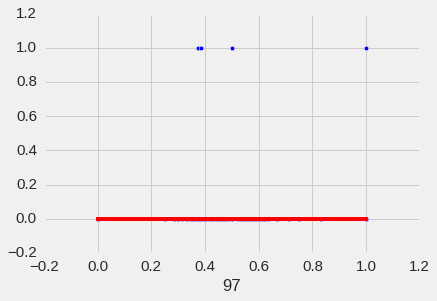

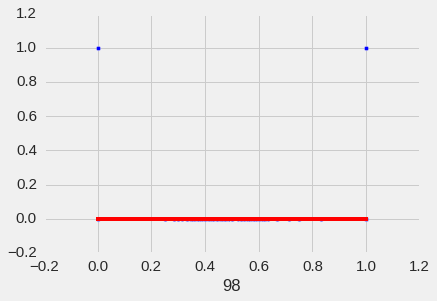

In [213]:
# plot the class predictions
for i in range(len(splitCsvF)):
    plt.figure()
    plt.scatter(X_new, userSwitch[i])
    plt.plot(X_new, log_reg[i], color='red')
    plt.xlabel(i)
    plt.show()
    

(250,)
(250, 8)
(250,)
training set score: 0.983957

test set score: 0.968254

training set score of lgr100: 1.000000

test set score of lgr100: 0.968254

training set score of lgr001: 0.951872

test set score of lgr001: 0.952381
[[ 0.05 -1.95 -0.14 -0.15 -0.01 -0.12  0.05  0.44]]


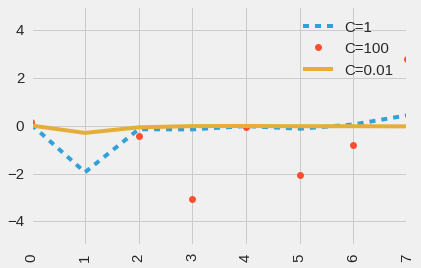

In [263]:
from sklearn.model_selection import train_test_split
print X[0][0].shape
id = 10
feature_cols = np.array([X[id][0],X[id][1],X[id][2],X[id][3],X[id][4],X[id][5],X[id][6],X[id][7]]).transpose()
print feature_cols.shape
print userSwitch[id].shape
X_train,X_test,y_train,y_test=train_test_split(feature_cols,userSwitch[id],stratify=userSwitch[id])
 
######default C=1#####
lgr=LogisticRegression().fit(X_train,y_train)
print("training set score: %f" % lgr.score(X_train, y_train))
print('\n'"test set score: %f" % lgr.score(X_test, y_test))
 
######increase C to 100#####
lgr100=LogisticRegression(C=100).fit(X_train,y_train)
print('\n'"training set score of lgr100: %f" % lgr100.score(X_train, y_train))
print('\n'"test set score of lgr100: %f" % lgr100.score(X_test, y_test))
 
######decrease C to 0.01#####
lgr001=LogisticRegression(C=0.01).fit(X_train,y_train)
print('\n'"training set score of lgr001: %f" % lgr001.score(X_train, y_train))
print('\n'"test set score of lgr001: %f" % lgr001.score(X_test, y_test))
 
import matplotlib.pyplot as plt
print lgr.coef_
plt.plot(lgr.coef_.T,'--',label='C=1')
plt.plot(lgr100.coef_.T,'o',label='C=100')
plt.plot(lgr001.coef_.T,'-',label='C=0.01')
plt.xticks(range(len(feature_cols.transpose())),rotation=90)
plt.ylim(-5,5)
plt.legend()
plt.show()